# Language Detection

In [1]:
from pathlib import Path
import glob
import os
import pandas as pd

In [2]:
NAMES_PATH = Path('data/names')

In [3]:
for name_file in NAMES_PATH.glob('*.txt'):
    print(name_file)

data\names\Arabic.txt
data\names\Chinese.txt
data\names\Czech.txt
data\names\Dutch.txt
data\names\English.txt
data\names\French.txt
data\names\German.txt
data\names\Greek.txt
data\names\Irish.txt
data\names\Italian.txt
data\names\Japanese.txt
data\names\Korean.txt
data\names\Polish.txt
data\names\Portuguese.txt
data\names\Russian.txt
data\names\Scottish.txt
data\names\Spanish.txt
data\names\Vietnamese.txt


In [4]:
from languageutils import *

## Load the Language Names Files

In [5]:
name_files = NAMES_PATH.glob('*.txt')

language_to_names = { file.name[:-4] : readLines(file) 
                                        for file in name_files }
languages = list(language_to_names.keys())
n_languages = len(language_to_names)

#### Langage Dictionary

In [6]:
languages

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [7]:
language_to_names['English'][10]

'Acton'

In [8]:
import random
language_summary = pd.DataFrame([{'Language': k, 
                                  'Number of Names': len(v), 
                                  'Random Name': random.choice(v)} 
                                     for k,v in language_to_names.items()]).set_index('Language')
language_summary.sort_values(['Number of Names'], ascending=False)

,Number of Names,Random Name
Language,,
Russian,9408,Dabahov
English,3668,Elzer
Arabic,2000,Nader
Japanese,991,Masudu
German,724,Schwartz
Italian,709,Abatantuono
Czech,519,Pech
Spanish,298,Alvarado
Dutch,297,Mulder


### Turning Names into Tensors

In [9]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_tensor('J').size())

print(line_to_tensor('Jones').size())

torch.Size([1, 57])
torch.Size([5, 1, 57])


## Creating the Network

In [10]:
import torch.nn as nn

class RecurrentNeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RecurrentNeuralNet, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RecurrentNeuralNet(n_letters, n_hidden, n_languages)

In [11]:
rnn

RecurrentNeuralNet(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

In [12]:
f'{n_letters} letters plus {n_hidden} features = input size of {n_letters + n_hidden}'

'57 letters plus 128 features = input size of 185'

In [13]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [14]:
output, next_hidden

(tensor([[-2.9198, -2.8764, -2.9860, -2.8830, -2.8451, -2.8856, -2.9189, -2.9801,
          -2.8894, -2.9044, -2.8245, -2.7949, -2.8031, -2.9143, -2.9370, -2.9129,
          -2.7949, -2.9886]], grad_fn=<LogSoftmaxBackward>),
 tensor([[ 0.0406,  0.0906, -0.0462, -0.0013, -0.0273,  0.0710, -0.0088, -0.0196,
          -0.0772, -0.0617,  0.0196,  0.0508,  0.0149, -0.0758,  0.0093, -0.0840,
           0.0689,  0.0105,  0.0180,  0.0522, -0.0119, -0.0009, -0.0590,  0.0672,
           0.1149,  0.1396, -0.0223, -0.0362, -0.0084,  0.0347,  0.0118, -0.0472,
           0.0043,  0.0708, -0.0834, -0.0164, -0.0805, -0.0096,  0.0162,  0.0130,
           0.1018, -0.0098,  0.0184,  0.0294,  0.0053, -0.0139,  0.0429, -0.0744,
          -0.0485, -0.0614, -0.0170,  0.1035,  0.0992, -0.0426,  0.1221, -0.0229,
          -0.0344, -0.1202, -0.0249,  0.0468, -0.0129, -0.0424,  0.0088, -0.0446,
          -0.0745,  0.0810,  0.0234, -0.0127, -0.0675, -0.0420,  0.1141, -0.0880,
          -0.0274,  0.0291, -0.0116, 

In [15]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output, next_hidden

(tensor([[-2.9198, -2.8764, -2.9860, -2.8830, -2.8451, -2.8856, -2.9189, -2.9801,
          -2.8894, -2.9044, -2.8245, -2.7949, -2.8031, -2.9143, -2.9370, -2.9129,
          -2.7949, -2.9886]], grad_fn=<LogSoftmaxBackward>),
 tensor([[ 0.0406,  0.0906, -0.0462, -0.0013, -0.0273,  0.0710, -0.0088, -0.0196,
          -0.0772, -0.0617,  0.0196,  0.0508,  0.0149, -0.0758,  0.0093, -0.0840,
           0.0689,  0.0105,  0.0180,  0.0522, -0.0119, -0.0009, -0.0590,  0.0672,
           0.1149,  0.1396, -0.0223, -0.0362, -0.0084,  0.0347,  0.0118, -0.0472,
           0.0043,  0.0708, -0.0834, -0.0164, -0.0805, -0.0096,  0.0162,  0.0130,
           0.1018, -0.0098,  0.0184,  0.0294,  0.0053, -0.0139,  0.0429, -0.0744,
          -0.0485, -0.0614, -0.0170,  0.1035,  0.0992, -0.0426,  0.1221, -0.0229,
          -0.0344, -0.1202, -0.0249,  0.0468, -0.0129, -0.0424,  0.0088, -0.0446,
          -0.0745,  0.0810,  0.0234, -0.0127, -0.0675, -0.0420,  0.1141, -0.0880,
          -0.0274,  0.0291, -0.0116, 

In [16]:
output.shape

torch.Size([1, 18])

In [17]:
hidden.shape

torch.Size([1, 128])

## Training

In [18]:
def get_language(output):
    top_n, top_i = output.topk(1)
    language_i = top_i[0].item()
    return languages[language_i], language_i

print(get_language(output))

('Spanish', 16)


In [19]:
import random

def choice_from(lst):
    return lst[random.randint(0, len(lst) - 1)]

def training_example():
    language = choice_from(languages)
    line = choice_from(language_to_names[language])
    language_index = languages.index(language)
    language_tensor = torch.tensor([language_index], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return language, line, language_tensor, line_tensor

for i in range(10):
    category, line, _, _ = training_example()
    print('category =', category, '/ line =', line,)

category = English / line = Reading
category = Czech / line = Meszes
category = Chinese / line = Siu
category = French / line = Pape
category = Chinese / line = Wang
category = Italian / line = Zunino
category = Japanese / line = Otomo
category = Spanish / line = Asis
category = Russian / line = Galstyan
category = Portuguese / line = Maria


### Loss Functions

In [20]:
loss_function = nn.NLLLoss()

In [21]:
learning_rate = 0.005 

def train(category_vector, line_vector):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_vector.size()[0]):
        output, hidden = rnn(line_vector[i], hidden)

    loss = loss_function(output, category_vector)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [22]:
import time
import math

n_iters = 60000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_elapsed(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_vector, line_vector = training_example()
    output, loss = train(category_vector, line_vector)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = get_language(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_elapsed(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 8% (0m 25s) 2.6640 Yun / Chinese ✗ (Korean)
10000 16% (0m 52s) 1.5585 Doan / Chinese ✗ (Vietnamese)
15000 25% (1m 18s) 2.2632 Auberton / Scottish ✗ (English)
20000 33% (1m 49s) 2.1745 Ton / Korean ✗ (Vietnamese)
25000 41% (2m 39s) 2.4187 Breda / Spanish ✗ (Italian)
30000 50% (3m 28s) 0.4854 Thuy / Vietnamese ✓
35000 58% (4m 40s) 1.7235 Hanania / Czech ✗ (Arabic)
40000 66% (5m 33s) 0.5937 Meeuweszen / Dutch ✓
45000 75% (6m 18s) 1.1977 Sepulveda / Spanish ✓
50000 83% (6m 28s) 4.2492 Jagoda / Japanese ✗ (Polish)
55000 91% (6m 38s) 1.5862 Krol / Scottish ✗ (Polish)
60000 100% (6m 48s) 0.3391 Mclaughlin / Scottish ✓


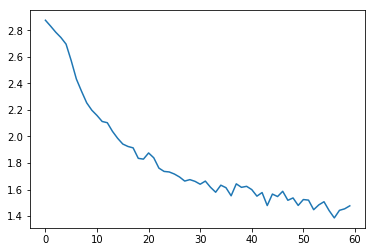

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

plt.figure()
plt.plot(all_losses)


In [24]:
rnn

RecurrentNeuralNet(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

## Evaluating the Results

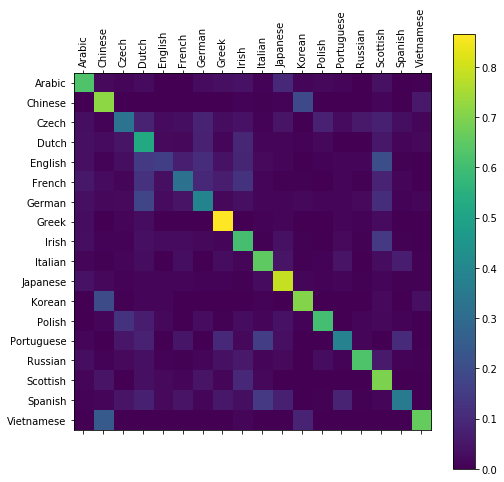

In [25]:
#Keep track of correct guesses in a confusion matrix
confusion_vector = torch.zeros(n_languages, n_languages)
n_confusion = 10000

# Just return an output given a line
def get_output(line_vector):
    hidden = rnn.initHidden()

    for i in range(line_vector.size()[0]):
        output, hidden = rnn(line_vector[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_vector, line_vector = training_example()
    output = get_output(line_vector)
    guess, guess_i = get_language(output)
    category_i = languages.index(category)
    confusion_vector[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_languages):
    confusion_vector[i] = confusion_vector[i] / confusion_vector[i].sum()

# Set up plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_vector.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Saving and reloading models

In [26]:
model_path = 'models/NameLanguageModel.rnn'
torch.save(rnn.state_dict(), model_path)

In [27]:
rnn.load_state_dict(torch.load(model_path))

In [28]:
def predict_name_language(name):
    name_tensor = line_to_tensor(name)
    output = get_output(name_tensor)
    guess, guess_i = get_language(output)
    return guess

In [29]:
predict_name_language('Allen')

'English'

In [30]:
customer_data = pd.read_csv('data/CustomerData.csv')

In [31]:
customer_data.head(20)

,Person,City,Agency
0,Panousis,Ortizmouth,Cambridge Travel
1,Zhang,Isabelview,Cambridge Travel
2,Li,Daniellechester,Pegasus Vacations
3,Moreau,Daniellechester,Cambridge Travel
4,Jansen,Ortizmouth,Cambridge Travel
5,Novak,Isabelview,Magellan Stays
6,Van Dijk,South Cynthia,Magellan Stays
7,McCarthy,Andreaside,Pegasus Vacations
8,Fearghal,Erinfurt,Cambridge Travel
9,Williams,New Stephenborough,Cambridge Travel


In [32]:
lang = customer_data.Person.apply(predict_name_language)
customer_data['Language'] = lang

In [33]:
customer_data

,Person,City,Agency,Language
0,Panousis,Ortizmouth,Cambridge Travel,Greek
1,Zhang,Isabelview,Cambridge Travel,Chinese
2,Li,Daniellechester,Pegasus Vacations,Vietnamese
3,Moreau,Daniellechester,Cambridge Travel,Irish
4,Jansen,Ortizmouth,Cambridge Travel,Dutch
5,Novak,Isabelview,Magellan Stays,Czech
6,Van Dijk,South Cynthia,Magellan Stays,Czech
7,McCarthy,Andreaside,Pegasus Vacations,Scottish
8,Fearghal,Erinfurt,Cambridge Travel,Irish
9,Williams,New Stephenborough,Cambridge Travel,Dutch


In [34]:
customer_data.to_csv('data/CustomerDataWithLanguage.csv', index=False)

In [35]:
sum([ len(x) for k,x in language_to_names.items()])

20074

In [36]:
len(language_to_names['English'])

3668

In [37]:
pd.DataFrame([ (k, len(x)) for k,x in language_to_names.items()])

,0,1
0,Arabic,2000
1,Chinese,268
2,Czech,519
3,Dutch,297
4,English,3668
5,French,277
6,German,724
7,Greek,203
8,Irish,232
9,Italian,709
